We are attempting to find predictors for energy generated at the Barra Bonita dam. We lag all the variables to which we have access and use random forests to find the most important indicators. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import datetime as dt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
import imgkit

In [2]:
df = pd.read_csv("../../Data/1999_2021/aggragate_daily_data_2000to2020.csv", index_col = "date").drop(labels = "Unnamed: 0", axis = 1)
df = df.rename(columns={"volume_used":"usable_volume"})

### Constructing the correlation matrix heat map and exporting as png

In [3]:
unlagged = df.corr().style.background_gradient(cmap ='coolwarm').render()
imgkit.from_string(unlagged, 'unlagged.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

### Adding lags to all variables.

In [4]:
for i in [7,14,30]:  
    df[['influent_flow_' + str(i)]] = df[['influent_flow']].shift(i)
    df[['usable_volume_' + str(i)]] = df[['usable_volume']].shift(i)
    df[['poured_flow_' + str(i)]] = df[['poured_flow']].shift(i)
    df[['water_level_' + str(i)]] = df[['water_level']].shift(i)
    df[['energy_stored_' + str(i)]] = df[['energy_stored']].shift(i)
    df[['maximum_demand_' + str(i)]] = df[['maximum_demand']].shift(i)
    df[['energy_generated_' + str(i)]] = df[['energy_generated']].shift(i)
    df[['effluent_flow_' + str(i)]] = df[['effluent_flow']].shift(i)
    
df = df.dropna()

In [5]:
#Exporting graphs for report

corr_matrix_7_14_30 = df.corr().style.background_gradient(cmap ='coolwarm')
imgkit.from_string(corr_matrix_7_14_30.render(), 'corr_matrix_7_14_30.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [6]:
#Exporting graph for presentation

df_trunc = df[['energy_charge','usable_volume','water_level','energy_stored','maximum_demand']]
corr_matrix_presentation = df_trunc.corr().style.background_gradient(cmap ='coolwarm')
imgkit.from_string(corr_matrix_presentation.render(), 'corr_matrix_presentation.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [7]:
#Correlations for energy generated

energy_generated_corr = df.corr()[['energy_generated']].sort_values(by = 'energy_generated',
                                                                    ascending = False).iloc[1:].head(10).style.background_gradient(cmap ='coolwarm')

# Regression Tree

Chose train size of (7303-n)/7303 so that we could test it on an n-day interval. (Not used here.) The strongest indicators of energy generated are turbine flow, effluent flow, energy generated lagged 3 days, effluent flow lagged 3 days.

In [8]:
X = df.drop(['energy_generated'], axis = 1)
y = df.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (7303-90)/7303, random_state = 0)

regr_tree_daily = DecisionTreeRegressor(max_depth = 2)
regr_tree_daily.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

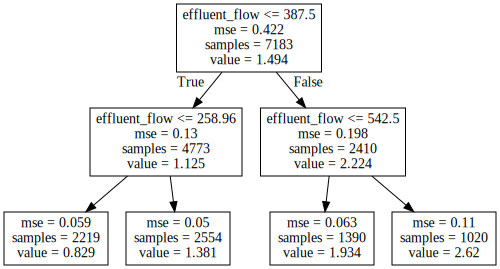

In [9]:
export_graphviz(regr_tree_daily, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

0.2316778805782003

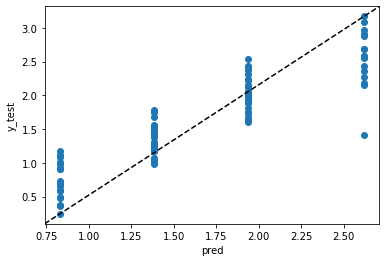

In [10]:
pred = regr_tree_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

## Bagging

Chose train size of (7303-n)/7303 so that we could test it on an n-day interval. 

In [11]:
X = df.drop(['energy_generated'], axis = 1)
y = df.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (7303-90)/7303, random_state = 0)

In [12]:
bagged_daily = RandomForestRegressor(max_features = 13, random_state = 1)
bagged_daily.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

0.0632779407566667

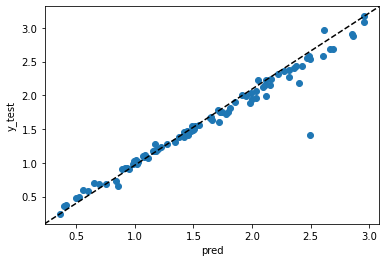

In [13]:
pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

**Choose a time chunk using .iloc to predict using the training model**

0.8756500373944445

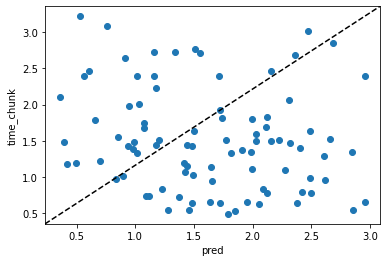

In [16]:
time_chunk = df[['energy_generated']].iloc[7000:7000+90].copy()

pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            time_chunk, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('time_chunk')

mean_absolute_error(time_chunk, pred)

## Random Forest

Chose train size of (7303-n)/7303 so that we could test it on an n-day interval. Forest shows that turbine flow and effluent flow are the most important indicators. Dropped these variables.

In [17]:
X = df.drop(['energy_generated'], axis = 1)
y = df.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (7303-90)/7303, random_state = 0)

random_forest_daily = RandomForestRegressor(n_estimators = 500, max_features = 7, random_state = 1)
random_forest_daily.fit(X_train, y_train)
pred = random_forest_daily.predict(X_test)
mean_absolute_error(y_test, random_forest_daily.predict(X_test))

0.08682805614800054

**Choosing time chunk on which to test forest's prediction**

In [18]:
time_chunk = df[['energy_generated']].iloc[7000:7000+90].copy()
mean_absolute_error(time_chunk, random_forest_daily.predict(X_test))

0.8618945310168887

Text(0.5, 0, 'Variable Importance (%)')

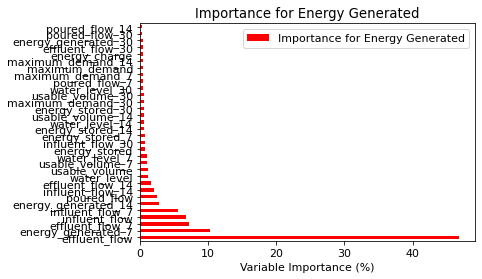

In [28]:
#Ranking most important variables

plt.rcParams.update({'font.size': 11})

Importance = pd.DataFrame({'Importance for Energy Generated':random_forest_daily.feature_importances_*100}, 
                          index = X.columns).sort_values(by = 'Importance for Energy Generated', 
                       axis = 0, 
                       ascending = False)
Importance.plot(kind = 'barh', color = 'r')
plt.title('Importance for Energy Generated')
plt.xlabel('Variable Importance (%)')

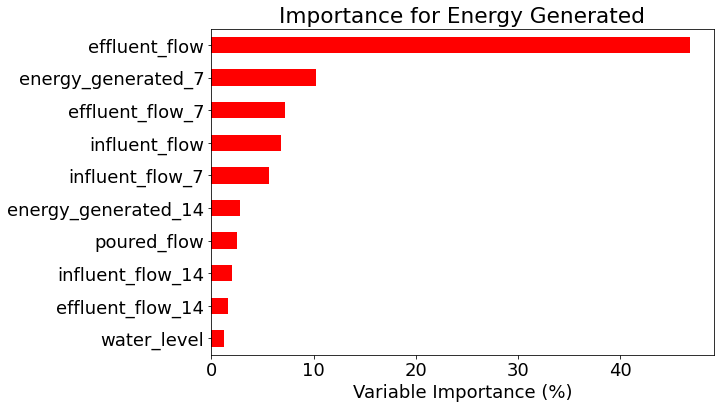

In [20]:
#10 most important variables

Importance_trunc = Importance.iloc[0:10]
bar_plot = Importance_trunc.sort_values(by = 'Importance for Energy Generated', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', 
                                              figsize=(9,6),
                                              legend = False)
plt.title('Importance for Energy Generated')
plt.xlabel('Variable Importance (%)')

## Boosting

Same as random forest above but boosted. Removed effluent flow as one of the variables because it dominated the importance (93%).

In [33]:
X = df.drop(['energy_generated','effluent_flow'], axis = 1)
y = df.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (7303-90)/7303, random_state = 0)

boosted_daily = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.2, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_daily.fit(X_train, y_train)
feature_importance = boosted_daily.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False,ascending = False)
rel_imp.head(10)

energy_generated_7     39.815484
influent_flow          16.722172
influent_flow_7         7.589643
poured_flow             2.612686
usable_volume_7         2.520920
water_level             2.458036
energy_stored_30        2.163278
energy_stored           2.123244
energy_generated_14     2.077471
energy_stored_14        1.774232
dtype: float64

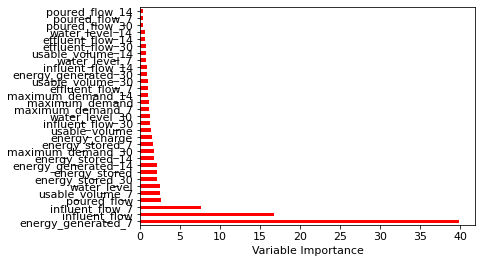

In [34]:
rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [35]:
mean_absolute_error(y_test, boosted_daily.predict(X_test))

0.20931082805689358

In [36]:
time_chunk = df[['energy_generated']].iloc[7000:7000+90].copy()
mean_absolute_error(time_chunk,  boosted_daily.predict(X_test))

0.8143271642808898

## Conclusion

It seems that turbine flow, energy generated, influent flow, and effluent flow are the best predictors of energy generated. Even lagged, these are better predictors than other variables (lagged and unlagged). Below is a correlation table of all these variables and some of their lags. 